In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime as dt
import simulate

In [2]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

### Defining market to simulate

In [3]:
start = dt.date(2020, 1, 1)
end = dt.date(2060, 1, 1)

Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

Plotting

Text(0.5, 1.0, 'Volatility')

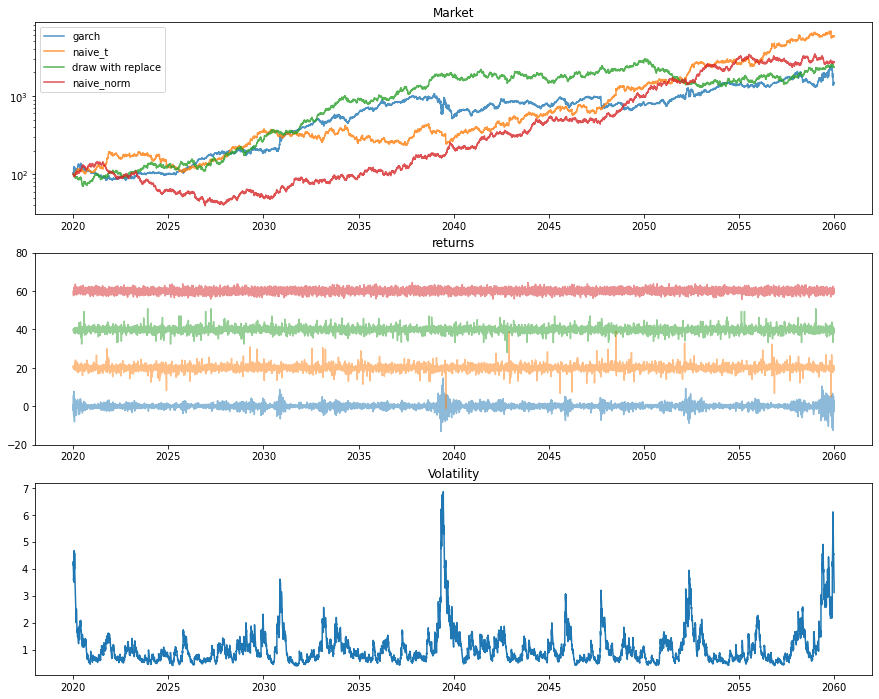

In [4]:
garch = Market.garch(log=True)
naive = Market.t_innovations(log=True)
draw = Market.draw(log = False, with_replacement = True, freq = 'D')
norm = Market.norm_innovations(log=False)

f, (ax1, ax2 , ax3) = plt.subplots(3, 1, figsize=(15,12))
ax1.plot(garch["Price"], alpha=.8)
ax1.plot(naive['Price'], alpha=.8)
ax1.plot(draw['Price'], alpha=.8)
ax1.plot(norm['Price'], alpha=.8)
ax1.set_title('Market')
ax1.legend(['garch', 'naive_t', 'draw with replace', 'naive_norm'])
ax1.set_yscale('log')

ax2.plot(garch["data"], alpha=.5)
ax2.plot(naive['Price'].pct_change()*100+20, alpha=.5)
ax2.plot(draw['Price'].pct_change()*100+40, alpha=.5)
ax2.plot(norm['Price'].pct_change()*100+60, alpha=.5)
ax2.set_ylim(-20, 80)
ax2.set_title('returns')
#ax2.set_yscale('LOG')

ax3.plot(garch["volatility"])
ax3.set_title('Volatility')
#ax3.set_yscale('LOG')

Simulating many markets

In [ ]:
def many_market(market, num_simulations):
    '''
    this simulated nobs markets with a horizon of years years

    return a dataframe with nobs columns and years*252 rows 
    '''
    data = pd.DataFrame()
    
    for i in range(num_simulations):
        data["Price_" + str(i)] = market.garch(log = True)['Price']
    return data

Descriptive statistic of simulations

In [ ]:
Market = simulate.Market(spx.iloc[-7500:, -2], start, end)
final_returns=many_market(Market, 1000).iloc[-1, :]

In [ ]:
plt.hist(final_returns, bins = 100, histtype='step', range=[-10000, 200000])
plt.show()

Prospect theory utility function

In [ ]:
def prospect_ut(price_before,price_after,alpha=0.88, beta=0.88, lambdas=2.25):
    '''
    in prospect theory, investors evaluate losses and gains differently. Assumes two different
    domains. Loss domain, where investment with negative returns are evaluted and gain domain for investment with positive return

    price_before:      the price in the begining of the evaluation period
    price_after:       the price in the end of the evulation period
    alpha:             risk aversion in gains
    beta:              risk seekingness in losses
    lambdas:           psycological harm of loss relativ to gains.

    example of price: price before: price of portfolio at 1st of january and price_after the price at 31st of janunary
    
    returns: utility u
    '''
    #absolute change
    x=price_after-price_before
    if x>=0: #if non negative absolute return
        u=x**alpha
    elif x<0:    #if negative absolute return
        u=-lambdas*(-x)**beta
    return u
    

In [ ]:
print(prospect_ut(100,250))

Constant relative risk aversion (CRRA) utility function


In [ ]:
def CRRA_ut():
    return